## 第 13 回　遺伝子データ解析

### 参考文献：先進ゲノム解析研究推進プラットフォーム (編集)、独習 Python バイオ情報解析、羊土社
---
---
### 目的：ヒト胚性幹細胞を胚様体とした分化過程のシングルセル RNA-Seq 解析データから論文用の図を作成する。

K.R. Moon et al., Visualizing structure and transitions in high-dimensional biological data, Nature Biotechnology, Vol. 37, 1482-1492, 2019.

---
---
## シングルセル解析 2
### 次元削減のつづき
---

In [1]:
!python --version
import sklearn
print('scikit-learn:', sklearn.__version__)

Python 3.11.5
scikit-learn: 1.3.2


### ライブラリのインポート

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### データの読込

In [3]:
# 遺伝子 ID と遺伝子のシンボルが記述された genes.tsv をデータフレーム genes に代入
genes = pd.read_csv('data/genes.tsv', sep='\t', index_col=0)

# 正規化テーブルから highly variable genes の項目のみ抽出した df_HVGs.gz をデータフレーム df_HVGs に代入
df_HVGs = pd.read_pickle('data/df_HVGs.gz')

# df_HVGs.gz の標準化後のデータ df_scaled.gz をデータフレーム df_scaled に代入
df_scaled = pd.read_pickle('data/df_scaled.gz')

---
---
### 主成分分析

<img src="figs/pca.jpg" width="500px">

In [4]:
# scikit-learn.ecomposition の PCA をインポートする
from sklearn.decomposition import PCA

# いくつの主成分を保存するかを n_components に指定する
# 何も指定しないとすべての主成分を保存するが、
# 第 1 主成分、第 2 主成分のみ使う場合は 2 と設定しておけばいい
pca_model = PCA(n_components=2)

# scikit-learn の多くのモデルは 観測値 x 特徴量 の行列を入力するが、
# ここでは 特徴量（遺伝子） x 観測値（細胞） のテーブルとなっているので、
# 転置（.T）して入力する
pca_model.fit(df_scaled.values.T)

# 変換すると，低次元空間での座標が観測値の数だけ出力される
pca_coords = pca_model.transform(df_scaled.values.T)

#### PCA の可視化

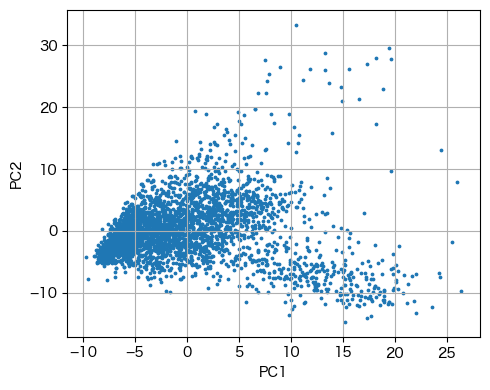

In [5]:
plt.figure(figsize=(5,4))
plt.scatter(pca_coords[:, 0], pca_coords[:, 1], s = 3)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.tight_layout()
plt.show()

- 1 つの点が、1 つの細胞を表している。
- データ全体の中で、どのくらいの細胞が密集しているのか、どの態度ばらけているのかがわかる。
- あくまでも、高次元空間をある平面で切り裂いたときの影を見ているにすぎない点には注意が必要。

#### 分化プロセスの 27 日間を 5 期間で色分け

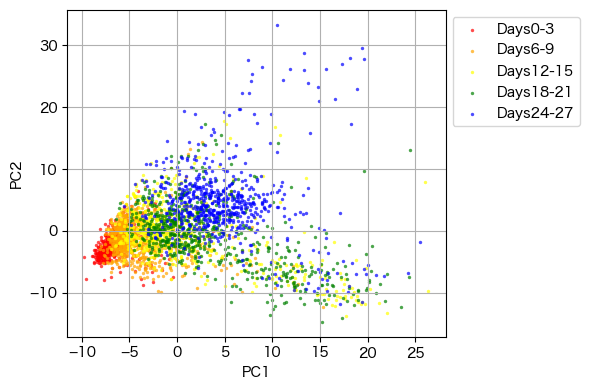

In [6]:
# 5 期間の名前のリスト
sample_labels = ['Days0-3', 'Days6-9', 'Days12-15', 'Days18-21', 'Days24-27']

# 5つのラベルに対応する色を辞書型で定義
label_to_colors = {
    'Days0-3': 'red',
    'Days6-9': 'orange',
    'Days12-15': 'yellow',
    'Days18-21': 'green',
    'Days24-27': 'blue'}

plt.figure(figsize=(6,4))

# ラベルごとに順番にプロットする
for label in sample_labels:
    # ここで使っている DataFrame は，細胞のバーコード配列とともに，
    # それぞれのラベル情報も持った "MultiIndex" の形式となっている
    # df_scaled のゼロ番目のレベルにラベルの情報が格納されているので，
    # それが現在の label 変数と一致するか否かの真偽値のリストを作って，
    # 変換後の座標 pca_coords の行のうち対応するもののみをプロットする
    cell_mask = (df_scaled.columns.get_level_values(0) == label)
    plt.scatter(
        pca_coords[cell_mask, 0],
        pca_coords[cell_mask, 1],
        color = label_to_colors[label],
        linewidth = 0,
        label = label,
        s = 6,
        alpha = 0.7
    )
plt.xlabel('PC1')
plt.ylabel('PC2')

# 図の邪魔にならないように凡例（レジェンド）の位置を指定する
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.tight_layout()
plt.show()

#### 特徴
- "Days0-3" の細胞（赤色）が狭い領域にかたまっている。
- 分化の日数が進むに従って徐々に右側の方にプロットされている。
- 分化プロセスがなんとなく見えるということは、データの中に分化プロセスを反映したなんらかの情報が埋め込まれていることを意味する。

#### 後々のために、この描画方法を関数 myplot として作成

In [7]:
def myplot(ax, coords, label_x, label_y):
    # 座標軸，プロットする座標，X軸のラベル，Y軸のラベルを入力して
    # 細胞ラベルごとに塗り分ける関数
    for label in sample_labels:
        cell_mask = df_scaled.columns.get_level_values(0) == label
        ax.scatter(coords[cell_mask, 0], coords[cell_mask, 1],
                   color=label_to_colors[label], linewidth=0,
                   label=label, s=6, alpha=.5)
    ax.set_xlabel(label_x)
    ax.set_ylabel(label_y)
    ax.set_xticks([])
    ax.set_yticks([])

主成分分析の強みの一つは、主成分（低次元空間のそれぞれの軸）が何を表現しているのかを簡単に調べられる点である。具体的には、どの特徴量（遺伝子）の値が大きいときに、二次元プロットのどこに配置されるかといったことである。これは、次元削減の結果を解釈する際に大いに役立つ。そのための指標が、**主成分負荷量**である。

#### **主成分負荷量**（principal component loadings）

- 各変数が新たに抽出された主成分にどれだけ寄与しているのかを数値で示すもの。この値が大きいほど、その変数は主成分の形成に大きく寄与していると言える。また、この値はマイナスになることもある。マイナスの場合、その変数が主成分と逆の関係性を持っていることを示す。

- 主成分得点と観測変数との相関係数のこと。主成分負荷量が大きいほど、その主成分は変数と強く相関しているということを表し、主成分をよく説明する変数であるといえる。主成分負荷量は 1 から -1 までの値をとる。第 $i$ 主成分 $z_i$ の主成分負荷量は、固有ベクトルに $z_i$ の分散（固有値）の正の平方根をかけることで求めることができる。

- それぞれの特徴量について、もとの高次元データにおける観測値と、次元削減したそれぞれのデータ点の主成分得点（プロットした低次元空間の座標のこと）の**Pearson 相関係数**として計算される。

- 主成分負荷量を $L$、固有値を $\lambda$、固有ベクトルを $V$ とすると
$$ L=\sqrt{\lambda}\bf{V} $$

#### 主成分負荷量の計算

In [8]:
# 主成分負荷量の計算
# pc loadings = eigenvector * sqrt(eigenvalue)

pc_loadings = pca_model.components_.T * np.sqrt(pca_model.explained_variance_)
print(pc_loadings.shape)
#pc_loadings

(2000, 2)


- pc_loadings は 2,000 遺伝子 $\times$ 2 主成分の行列
- 遺伝子ごとに、第 1、第 2 主成分に対する主成分負荷量のデータが入っている。

#### pc_loadings から、第 1 主成分に強く効く遺伝子の上位 10 個を取り出す

In [9]:
# 第 1 主成分に対する主成分負荷量、絶対値の大きい順に上から 10 個
# ゼロ列目について、絶対値（abs）にして、ソート後のインデックスを取り出して（argsort）、
# 降順に並び替えて（[::-1]）、上位　10　個を取り出す（[:10]）
top10_pc1_ind = np.argsort(np.abs(pc_loadings[:, 0]))[::-1][:10]

# 対応する遺伝子インデックスを df_scaled から取り出して、
# 遺伝子名などの情報が入った genes からその遺伝子の情報を取り出す
top10_pc1_genes = genes.loc[df_scaled.index[top10_pc1_ind], :]
top10_pc1_genes['PC_Loadings'] = pc_loadings[top10_pc1_ind, 0]
display(top10_pc1_genes)

,Symbol,PC_Loadings
GeneID,,
ENSG00000168542,COL3A1,0.802236
ENSG00000011465,DCN,0.764309
ENSG00000139329,LUM,0.740281
ENSG00000108821,COL1A1,0.719054
ENSG00000164692,COL1A2,0.695177
ENSG00000137309,HMGA1,-0.674208
ENSG00000113140,SPARC,0.666252
ENSG00000166482,MFAP4,0.600343
ENSG00000164093,PITX2,0.592756


- COL3A1 の発現量が大きい細胞は図の右側（正の相関）に配置されている。
- HMGA1 の発現量が大きい細胞は図の左側（負の相関）に配置されている。

#### pc_loadings から第 2 主成分に強く効く遺伝子の上位 10 個を取り出す

In [10]:
# 第二主成分に対する主成分負荷量についても同様
top10_pc2_ind = np.argsort(np.abs(pc_loadings[:, 1]))[::-1][:10]
top10_pc2_genes = genes.loc[df_scaled.index[top10_pc2_ind], :]
top10_pc2_genes['PC_Loadings'] = pc_loadings[top10_pc2_ind, 1]
display(top10_pc2_genes)

,Symbol,PC_Loadings
GeneID,,
ENSG00000231500,RPS18,-0.690658
ENSG00000197958,RPL12,-0.624435
ENSG00000164587,RPS14,-0.586759
ENSG00000167526,RPL13,-0.577191
ENSG00000229117,RPL41,-0.551067
ENSG00000167552,TUBA1A,0.540515
ENSG00000174748,RPL15,-0.539070
ENSG00000186468,RPS23,-0.538927
ENSG00000140988,RPS2,-0.523360


- RPS18 の発現量が大きい細胞は図の下側（負の相関）に配置されている。
- TUBA1A の発現量が大きい細胞は図の上側（正の相関）に配置されている。

#### 特定の遺伝子の発現量に応じた色で細胞を塗り分ける

In [11]:
# 遺伝子名を指定して図を描画する関数

def myplot_gene_expression(target_gene):
    # 遺伝子シンボルに対応する遺伝子のインデックスを取り出す
    target_gene_id = genes[genes['Symbol'] == target_gene].index[0]
    
    # もともとのデータ（標準化前）からその遺伝子の発現量を取り出す
    expr_values = df_HVGs.loc[target_gene_id, :]
    
    plt.figure(figsize=(5,4))
    
    # color map（値と色の関係）をviridisとして，colorに発現量の値を指定する
    sc = plt.scatter(
        pca_coords[:, 0],
        pca_coords[:, 1],
        s = 6,
        alpha = 0.7,
        c = expr_values,
        cmap = 'viridis'
    )
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(target_gene)
    plt.colorbar(sc)
    plt.grid()
    plt.tight_layout()
    plt.show()

#### 第 1 主成分に対する主成分負荷量がトップの COL3AI 遺伝子の発現量

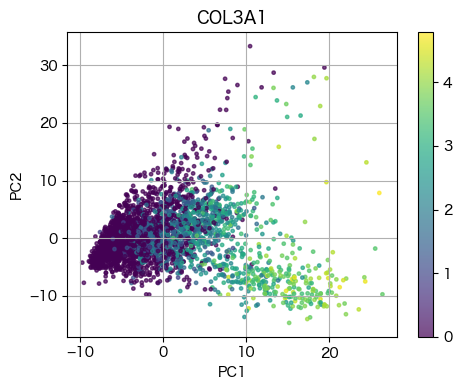

In [12]:
myplot_gene_expression('COL3A1')

#### 第 2 主成分に対する主成分負荷量（の絶対値が）がトップの RPS18 遺伝子の発現量

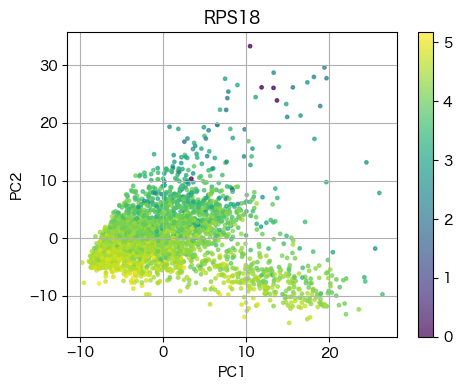

In [13]:
myplot_gene_expression('RPS18')

#### バイプロット

バイプロット（biplot）は、主成分分析（PCA）の結果を視覚化する手法の一つ。このプロットでは、主成分分析によって得られたデータの主成分スコア（つまり、元のデータが主成分空間に射影された点）と、主成分負荷量（元の変数が主成分空間にどのように影響を与えているかを示すベクトル）の両方を同時に描画する。

バイプロットの主な特徴は以下：

1. **データポイントの表示**：
   - データセット内の各サンプルは、主成分分析によって抽出された最初の数個の主成分を基にした低次元空間にプロットされる。
   - これにより、データのパターン、クラスタ、外れ値などが視覚的に識別できるようになる。

2. **主成分負荷量の表示**：
   - 元の特徴（変数）は、それぞれが主成分にどの程度影響を与えているかを示すベクトルとしてプロットされる。
   - ベクトルの方向と長さは、対応する変数が主成分にどのように関連しているかを示す。長さが長いほど、その変数は主成分に大きな影響を与えている。

バイプロットは、多次元データの構造を理解するのに役立ち、特に変数間の関係や変数とサンプルの関係を探る際に有用。ただし、バイプロットはデータの次元が高い場合や、主成分がデータの多様性を完全に捉えきれていない場合には、解釈が難しくなることがある。

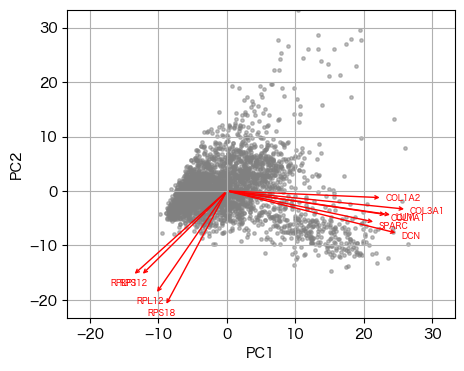

In [14]:
# 主成分負荷量の二乗和の上位 10 遺伝子のインデックスと遺伝子シンボルを取り出す
top10_ind = np.argsort((pc_loadings ** 2).sum(axis=1))[::-1][:10]
symbols = genes.loc[df_scaled.index[top10_ind], :]['Symbol']

plt.figure(figsize=(5,4))

plt.scatter(
    pca_coords[:, 0],
    pca_coords[:, 1],
    s = 6,
    alpha = 0.5,
    color = 'gray'
)

# 主成分負荷量の値は最大で 1，-1で見にくいので適当にスケールする
max_val = pca_coords.max()

for g_ind, symbol in zip(top10_ind, symbols):
    plt.annotate(
        symbol,
        xy = (0, 0),
        fontsize=6,
        xytext = max_val*pc_loadings[g_ind, :],
        color = 'red',
        arrowprops = {'color':'red', 'arrowstyle':'<-'}
    )

plt.xlim(-max_val+10, max_val)
plt.ylim(-max_val+10, max_val)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.show()

#### 寄与率

主成分分析における「寄与率」は、データセットの分散（情報量）のうち、各主成分がどれだけの割合を占めているかを示す指標。寄与率は、データの全分散に対する各主成分の分散の割合で計算され、一般的にはパーセンテージ（%）で表される。

**寄与率の計算方法**

   - 各主成分の寄与率は、その主成分の分散（固有値）を全主成分の分散の合計で割ることによって求められる。
   - 数式で表すと、第 $k$ 主成分の寄与率 $\mathrm{CR}_k$ は以下のように計算される：
     $$\mathrm{CR}_k = \frac{\lambda_k}{\sum_{i=1}^{n} \lambda_i} \times 100 \% $$
     ここで、$\lambda_k$ は第 $k$ 主成分の固有値、$n$ は主成分の総数。

In [15]:
# 各主成分の寄与度の計算（取得）

pca_model.explained_variance_ratio_

array([0.03517091, 0.02212961])

第 1 主成分の寄与度は約 3.5%、第 2 主成分の寄与度は約 2.2%

#### 累積寄与率

主成分分析における「累積寄与率」は、最初の数個の主成分がデータの全分散に対してどれだけの割合で寄与しているかを示す。
例えば、最初の3つの主成分の累積寄与率が80%であれば、データの80%の分散（情報量）がこれら3つの主成分によって説明されることを意味する。



**重要性**

- 寄与率と累積寄与率は、PCAにおいて重要な情報を持つ主成分を特定するために使用される。
- 通常、累積寄与率がある閾値（例えば70%～90%）を超えるまでの主成分を選択することで、元のデータの重要な特徴を保持しつつ次元を削減することができる。

これにより、主成分分析はデータの可視化、ノイズの除去、特徴抽出、データ圧縮などに効果的に利用される。

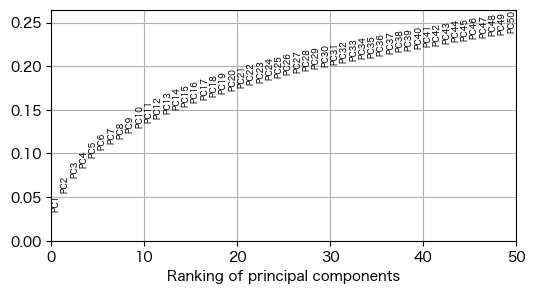

In [16]:
# 50 主成分の累積寄与率を見てみる

n_pcs = 50
pca_model = sklearn.decomposition.PCA(n_components=n_pcs)
pca_model.fit(df_scaled.values.T)

# numpy.cumsum()関数で累積和に変換する
cumulative_variance_ratio = np.cumsum(pca_model.explained_variance_ratio_)

plt.figure(figsize=(6, 3))

for i in range(n_pcs):
    # 主成分ごとにそれまでのパーセンテージの累積和の位置にプロットする
    plt.annotate(
        'PC'+str(i+1),
        xy = (i, cumulative_variance_ratio[i]),
        ha = 'left',
        rotation = 90,
        fontsize = 6
    )

plt.xlim(0, n_pcs)
plt.ylim(0, cumulative_variance_ratio.max()*1.1)
plt.xlabel('Ranking of principal components')
plt.ylabel('')
#sns.despine()
plt.grid()
plt.show()

---
---
### t-SNE

<img src="figs/tsne.jpg" width="500px">

**パープレキシティ（perprexity）**
- 高次元空間上の正規分布の「幅」のようなもの。データの分布度合いに応じて「幅」を可変にする。

#### t-SNE の実例

- すべての特徴量を使って解析することもできるが、主成分分析を使って特徴量の次元を削減しておく。
- 以下では、50 個分の主成分を使うことにする。

In [17]:
# 50 個の主成分で線形次元削減しておく
# （重要なばらつきはだいたいキャプチャできているはず，と考えておく）

PCs = 50
pca = sklearn.decomposition.PCA(n_components=PCs)
pcscores = pca.fit_transform(df_scaled.values.T)

# 主成分得点を格納した新たな DataFrame を定義する
# 行方向に各細胞、列方向に第 1 主成分から第 50 主成分までが並ぶ
df_pc = pd.DataFrame(
    pcscores,
    index = df_scaled.columns,
    columns=['PC'+str(i+1) for i in range(PCs)]
)

#display(df_pc.iloc[:5, :5])
df_pc

PC1        PC2        PC3        PC4  \
Days0-3   AAACCGTGGCTACA-1  -7.972695  -3.564716   5.242470   0.524536   
          AAACGCTGTAGCGT-1  -7.606931  -4.558112  10.092944  -1.665810   
          AAAGATCTGGTACT-1  -7.491873  -3.032769   5.793508  -0.927031   
          AAAGATCTTCCTTA-1  -7.323264  -2.726932  10.319604  -3.176210   
          AAAGTTTGAGCTCA-1  -8.232689  -3.528740   6.255281  -1.737008   
...                               ...        ...        ...        ...   
Days24-27 TTTCAGTGTGCTTT-1   5.812486   5.420701  -2.904744  -6.761632   
          TTTCCAGATGAAGA-1  -0.724815   5.497507   0.151975   5.448793   
          TTTCGAACCTATGG-1   5.303686  14.231732  -0.532354  14.955645   
          TTTCGAACTGAGAA-1  12.956267   3.141494  -3.044109   0.097959   
          TTTGCATGTAGACC-1  13.785086  -8.377266  -1.400182   2.938918   

                                 PC5       PC6       PC7       PC8       PC9  \
Days0-3   AAACCGTGGCTACA-1  1.228564 -5.060383 -1.953724 -1.242926 -2.890867   
          AAACGCTGTAGCGT-1  0.263677 -5.599537 -2.499589 -0.725168 -2.495820   
          AAAGATCTGGTACT-1  0.203841 -3.801783 -1.801373 -0.216189 -0.991084   
          AAAGATCTTCCTTA-1  1.193410 -4.023987 -2.260303 -0.804320 -1.211697   
          AAAGTTTGAGCTCA-1 -0.677576 -3.835218 -1.666889 -1.119808 -0.501791   
...                              ...       ...       ...       ...       ...   
Days24-27 TTTCAGTGTGCTTT-1  0.231944  0.677203 -1.806297  1.020237  1.524013   
          TTTCCAGATGAAGA-1 -2.186520  1.047006 -0.309109 -4.133866 -1.877792   
          TTTCGAACCTATGG-1 -2.181734 -0.769371 -2.931233 -2.451109 -0.773628   
          TTTCGAACTGAGAA-1  2.638536 -2.338696 -2.061795 -1.562924 -2.155347   
          TTTGCATGTAGACC-1 -5.975713 -3.214456 -0.943936  1.888231  0.063094   

                                PC10  ...      PC41      PC42      PC43  \
Days0-3   AAACCGTGGCTACA-1 -0.838484  ... -0.515704  1.153251  0.830785   
          AAACGCTGTAGCGT-1  2.972963  ...  0.209412 -0.548884  0.501776   
          AAAGATCTGGTACT-1  1.603203  ... -0.290012  0.043621  0.634076   
          AAAGATCTTCCTTA-1  2.346053  ... -0.169513 -0.588683  0.802190   
          AAAGTTTGAGCTCA-1  2.827921  ...  0.376934  0.702155  0.847737   
...                              ...  ...       ...       ...       ...   
Days24-27 TTTCAGTGTGCTTT-1 -4.074856  ... -0.621220  0.390211  0.276084   
          TTTCCAGATGAAGA-1  0.293777  ...  0.135904 -1.781150 -0.975079   
          TTTCGAACCTATGG-1 -3.586377  ...  4.117028  0.178748 -0.440600   
          TTTCGAACTGAGAA-1 -1.882719  ...  2.512522 -0.622052 -0.824633   
          TTTGCATGTAGACC-1  4.089382  ... -1.478065  0.571617  0.198229   

                                PC44      PC45      PC46      PC47      PC48  \
Days0-3   AAACCGTGGCTACA-1  0.625329 -1.799242  0.352214  0.430092  1.384655   
          AAACGCTGTAGCGT-1 -0.498310 -0.381241  0.319918 -1.347535 -0.135695   
          AAAGATCTGGTACT-1  0.868409  0.084761 -0.807057  0.184839 -0.345995   
          AAAGATCTTCCTTA-1  0.187865 -0.036180  0.893271  0.326427 -0.073423   
          AAAGTTTGAGCTCA-1 -1.089093  0.039868  0.347459 -0.417190 -1.084317   
...                              ...       ...       ...       ...       ...   
Days24-27 TTTCAGTGTGCTTT-1 -3.433326  1.524884 -0.574603 -0.592568  2.508272   
          TTTCCAGATGAAGA-1  0.810456  1.357134  0.441840 -0.094671  2.195012   
          TTTCGAACCTATGG-1 -4.686343  0.043475  3.780381  0.067888 -1.229486   
          TTTCGAACTGAGAA-1 -2.596189 -0.691752 -1.854700  2.087729 -2.790961   
          TTTGCATGTAGACC-1 -1.423551 -1.237674 -3.932622  0.221328 -1.281422   

                                PC49      PC50  
Days0-3   AAACCGTGGCTACA-1  0.335386  2.169080  
          AAACGCTGTAGCGT-1  0.013712 -0.520835  
          AAAGATCTGGTACT-1  0.012826 -0.398339  
          AAAGATCTTCCTTA-1  0.865293  0.146056  
          AAAGTTTGAGCTCA-1  0.117392  0.353482  
...                         

#### scikit-learn の t-SNE を用いる

In [18]:
# scikit-learn の t-SNE をインポートする
from sklearn.manifold import TSNE

# モデルのパラメータの指定
# 二次元に圧縮、初期配置はランダムではなく主成分分析の結果で決める
tsne_model = TSNE(n_components=2, init='pca', verbose=1)

# 実際に t-SNE を動かして、次元削減後の二次元座標を得る
tsne_coords = tsne_model.fit_transform(df_pc.values)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3102 samples in 0.000s...
[t-SNE] Computed neighbors for 3102 samples in 0.152s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3102
[t-SNE] Computed conditional probabilities for sample 2000 / 3102
[t-SNE] Computed conditional probabilities for sample 3000 / 3102
[t-SNE] Computed conditional probabilities for sample 3102 / 3102
[t-SNE] Mean sigma: 3.736983
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.203537
[t-SNE] KL divergence after 1000 iterations: 1.373145


#### tsne_coords の可視化

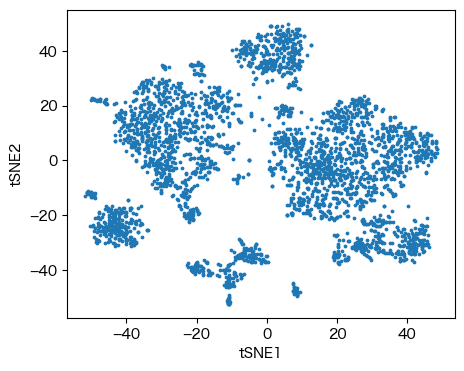

In [19]:
#sns.set(style='white')
plt.figure(figsize=(5,4))
plt.scatter(
    tsne_coords[:, 0],
    tsne_coords[:, 1],
    s=3,
    alpha=1
)
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
#sns.despine()
#plt.grid()
plt.show()

#### 分化プロセスの 27 日間を 5 期間で色分け
- デフォルトのパープレキシティは 30

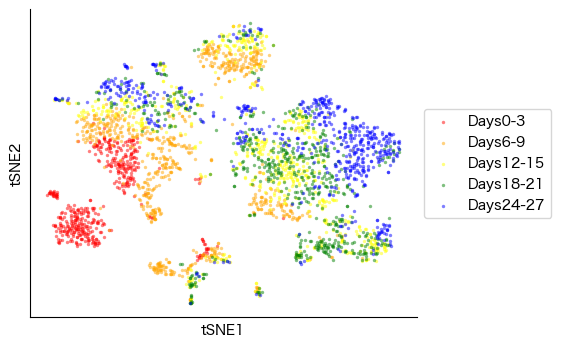

In [20]:
fig, ax = plt.subplots(figsize=(5,4))
myplot(ax, tsne_coords, label_x='tSNE1', label_y='tSNE2')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()
plt.show()

- ほぼ時系列に沿って分布しているように見えるが、特定の期間でクラスタを構成するといった傾向は見られない。
- 特に、時系列の後半になるにつれて、細胞ラベル（サンプリング日時）による分離は見られにくくなり、時系列とは異なる要素でパターンが分離するように見える。

#### パープレキシティを変えて計算

パープレキシティを 30, 5, 500 にして比較

In [21]:
# Perplexityを5にした場合，30にした場合（デフォルト．計算済み），500にした場合で比較してみる

tsne_model_perp5 = TSNE(
    n_components = 2,
    init = 'pca',
    verbose = 1,
    perplexity = 5
)

tsne_coords_perp5 = tsne_model_perp5.fit_transform(df_pc.values)

tsne_model_perp500 = TSNE(
    n_components = 2,
    init = 'pca',
    verbose = 1,
    perplexity = 500
)

tsne_coords_perp500 = tsne_model_perp500.fit_transform(df_pc.values)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 3102 samples in 0.001s...
[t-SNE] Computed neighbors for 3102 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3102
[t-SNE] Computed conditional probabilities for sample 2000 / 3102
[t-SNE] Computed conditional probabilities for sample 3000 / 3102
[t-SNE] Computed conditional probabilities for sample 3102 / 3102
[t-SNE] Mean sigma: 2.399038
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.399811
[t-SNE] KL divergence after 1000 iterations: 1.645663
[t-SNE] Computing 1501 nearest neighbors...
[t-SNE] Indexed 3102 samples in 0.000s...
[t-SNE] Computed neighbors for 3102 samples in 0.309s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3102
[t-SNE] Computed conditional probabilities for sample 2000 / 3102
[t-SNE] Computed conditional probabilities for sample 3000 / 3102
[t-SNE] Computed conditional probabilities for sample 3102 / 3102
[t-SNE] Mean sigma: 6.89919

#### 分化プロセスの 27 日間を 5 期間で色分け

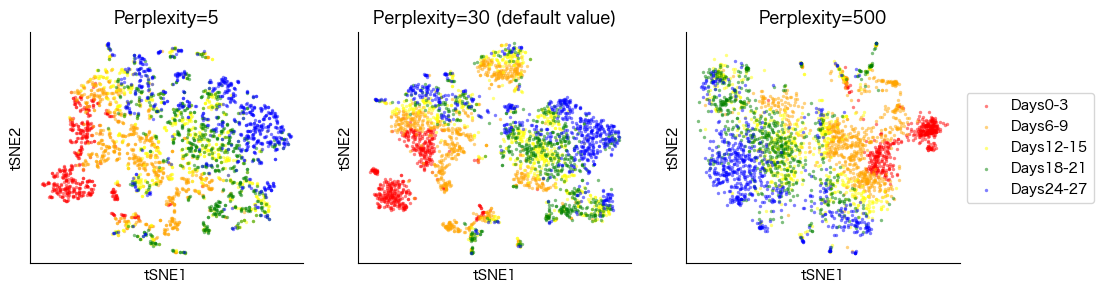

In [22]:
fig = plt.figure(figsize=(12, 3))

ax1 = fig.add_subplot(1, 3, 1)
myplot(ax1, tsne_coords_perp5, label_x='tSNE1', label_y='tSNE2')
ax1.set_title('Perplexity=5')

ax2 = fig.add_subplot(1, 3, 2)
myplot(ax2, tsne_coords, label_x='tSNE1', label_y='tSNE2')
ax2.set_title('Perplexity=30 (default value)')

ax3 = fig.add_subplot(1, 3, 3)
myplot(ax3, tsne_coords_perp500, label_x='tSNE1', label_y='tSNE2')
ax3.set_title('Perplexity=500')
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.despine()
plt.show()

- パープレキシティの値によって、プロットの見た目がかなり変わる。
- パープレキシティは、近傍何個のデータ点との関係性を維持するように次元削減するか、といった解釈が可能。
  - パープレキシティ 5 の場合は、それぞれの点にとって近傍数個のデータ点との関係はほぼ正確に表現されるが、もっと離れた点との距離関係はあまり維持されていないことになる。
- パープレキシティ 5 の場合（左）は、細胞が全体としてぼんやりとした球形に配置され、グローバルな構造らしきものはほとんど見えない。
- パープレキシティ 500 の場合（右）は、全体が狭いエリアに圧縮されたような表現になり、大まかな全体像は見えやすくなっているものの、細胞ごとの細かな違いを観測することは難しい。
- 実際のデータ分析では、複数のパープレキシティの設定で計算し、それらの結果を比較するべきで、複数の結果で同様に観測されるクラスタが存在するならば、それは確かに高次元空間において特有のパターンを形成している可能性がある。

---
### UMAP

<img src="figs/comp.jpg" width="600px">

ここで、以下の式を最もフィットするように $q_{ij}$ の $a$, $b$ を決める。

$$\Phi(||y_i-y_j||)=\left\{
\begin{array}{cl}
1&\mathrm{if}\:||y_i-y_j||\le\mathrm{min\_dist}\\
\exp(-||y_i-y_j||-\mathrm{min\_dist})&\mathrm{otherwise}
\end{array}
\right.
$$

- n_neighbors: t-SNE のパープレキシティと似て、高次元空間においてデータ点が構成する多様体の構造をどのように捉えるかを本質的に決めるパラメータ。
  - 大きくすればそれぞれのデータ点についてより多くの「近傍」の情報を取り込むため、多様体のグローバルな構造を情報として重視する傾向が強くなり、小さくすればよりローカルな情報を重視する。

- min_dist: 抽出された情報を低次元空間でどのように表現するかを決めるパラメータ。
  - 大きくすれば低次元空間におけるそれぞれの点が押し広げられるため、細かな構造が表現されやすくなり、小さくすれば点は詰め込まれて表現されるものの全体の構造が見えやすくなる。

#### UMAP の実例

- すべての特徴量を使って解析することもできるが、主成分分析を使って特徴量の次元を削減しておく。
- 以下では、50 個分の主成分を使うことにする。

In [29]:
# UMAPをインポートする
import umap
print('UMAP:', umap.__version__)

# 何次元に落とすか（n_components）を与えるとともに
# n_neighbors，min_distのパラメータを設定する

umap_model = umap.UMAP(n_components = 2,
                       n_neighbors = 30,
                       min_dist = 0.3,
                       random_state = 42,
                       verbose = False)

# 実際にデータを変換する
umap_coords = umap_model.fit_transform(df_scaled.values.T)

AttributeError: module 'umap' has no attribute '__version__'

#### umap_coords を分化プロセスの 27 日間を 5 期間で色分け

In [ ]:
fig, ax = plt.subplots(figsize=(5,4))
myplot(ax, umap_coords, label_x='UMAP1', label_y='UMAP2')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()
plt.show()

- 主成分分析や t-SNE とは違った感じで、両者の中間的なイメージ。

#### min_dist は固定し、n_neighbors を変えて可視化
- n_neighbors を 5 個、30 個（計算済み）、500 個で比較する

In [ ]:
# n_neighbors を 5 個、30 個（計算済み）、500 個で比較する

umap_model_nn5 = umap.UMAP(n_components=2,
                           n_neighbors=5, min_dist=0.3,
                           random_state=42, verbose=False)
umap_coords_nn5 = umap_model_nn5.fit_transform(df_scaled.values.T)

umap_model_nn500 = umap.UMAP(n_components=2,
                             n_neighbors=500, min_dist=0.3,
                             random_state=42, verbose=False)
umap_coords_nn500 = umap_model_nn500.fit_transform(df_scaled.values.T)

#### 分化プロセスの 27 日間を 5 期間で色分け

In [ ]:
fig = plt.figure(figsize=(12, 3))

ax1 = fig.add_subplot(1, 3, 1)
myplot(ax1, umap_coords_nn5, label_x='UMAP1', label_y='UMAP2')
ax1.set_title('n_neighbors=5')

ax2 = fig.add_subplot(1, 3, 2)
myplot(ax2, umap_coords, label_x='UMAP1', label_y='UMAP2')
ax2.set_title('n_neighbors=30')

ax3 = fig.add_subplot(1, 3, 3)
myplot(ax3, umap_coords_nn500, label_x='UMAP1', label_y='UMAP2')
ax3.set_title('n_neighbors=500')
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.despine()
plt.show()

- n_neighbors が極端に大きい場合、全体の中での相対的な逸関係はわかるものの、それ俺のクラスタや、それらの接続関係といった局所的な構造に関する情報はほぼ失われてしまった。

#### min_dist を変えて可視化
- min_dist、0.01、0.03、0.8 で比較

In [ ]:
# min_dist、0.01、0.03、0.8 で比較

umap_model_md001 = umap.UMAP(n_components=2,
                             n_neighbors=30, min_dist=0.01,
                             random_state=42, verbose=False)
umap_coords_md001 = umap_model_md001.fit_transform(df_scaled.values.T)

umap_model_md080 = umap.UMAP(n_components=2,
                             n_neighbors=30, min_dist=0.8,
                             random_state=42, verbose=False)
umap_coords_md080 = umap_model_md080.fit_transform(df_scaled.values.T)

#### 分化プロセスの 27 日間を 5 期間で色分け

In [ ]:
# 11-27
fig = plt.figure(figsize=(12, 3))

ax1 = fig.add_subplot(1, 3, 1)
myplot(ax1, umap_coords_md001, label_x='UMAP1', label_y='UMAP2')
ax1.set_title('min_dist=0.01')

ax2 = fig.add_subplot(1, 3, 2)
myplot(ax2, umap_coords, label_x='UMAP1', label_y='UMAP2')
ax2.set_title('min_dist=0.3')

ax3 = fig.add_subplot(1, 3, 3)
myplot(ax3, umap_coords_md080, label_x='UMAP1', label_y='UMAP2')
ax3.set_title('min_dist=0.8')
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.despine()
plt.show()

- min_dist が小さい場合、点が詰め込まれた表現となるが、大きくするとそれらがより広げられた表現となった。

### まとめ

次元削減は唯一の「正解」といえる低次元表現を探すものではないし、ましてや綺麗な二次元プロットを描くための道具でもない。さまざまな切り口で次元削減を繰り返すことで、高次元においてデータがどのように分布していたのか、想いを馳せることが重要。